### 7.3 K-means によるクラス分類用の特徴量生成

In [34]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [35]:
class KMeansFeaturizer:
    """
    数値データをk-meansのクラスタIDに変換する
    
    ターゲット変数yが存在する場合，クラス分類の境界を
    より重視したクラスタリングの結果を得るために，ターゲット変数をスケーリングして
    入力データに含めてk-meansに渡す
    """
    
    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder(categories='auto').fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        # 各クラスタの中心を見つける
        if y is None:
            # ターゲット変数がない場合、ふつうのk-meansを実行します。
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # ターゲット変数がある場合
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        km_model = KMeans(n_clusters=self.k, init=km_model_pretrain.cluster_centers_[:,:2], n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
    
    def transform(self, X, y=None):
        # 元も近いクラスタIDを返す
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

### ターゲット変数の有無によるK-means の結果の違い

In [36]:
%matplotlib inline
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

training_data, training_labels = make_moons(n_samples=2000, noise=0.2)
kmf_hint = KMeansFeaturizer(k=100, target_scale=10).fit(training_data, training_labels)
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0).fit(training_data, training_labels)

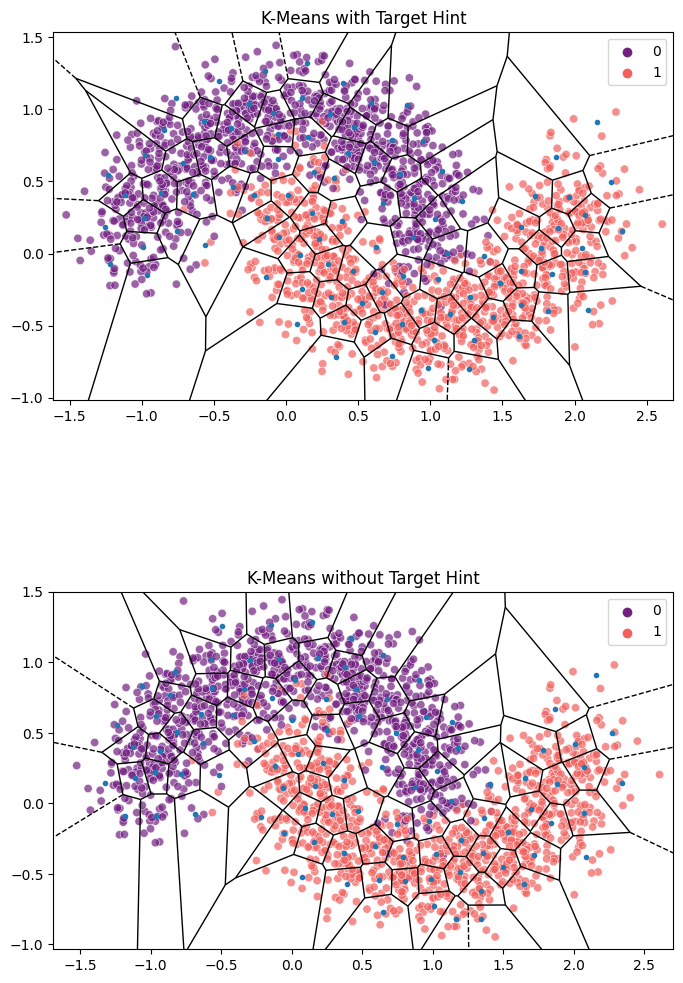

In [37]:
import seaborn as sns

def kmeans_voronoi_plot(X, y, cluster_centers, ax):
   """
   k-meansのクラスタの境界からボロノイ図を描き，データに重ね合わせる
   """
   sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax, palette='magma', alpha=0.7)
    
   # voronoi_plot_2d関数内で、ishold関数が利用されているが、matplotlib 2.0以降では廃止されているため設定
   def ishold():
       return True
   ax.ishold = ishold
    
   vor = Voronoi(cluster_centers)
   voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

fig = plt.figure(figsize=(8, 12))
ax = plt.subplot(211, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, ax)
ax.set_title('K-Means with Target Hint')
ax2 = plt.subplot(212, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_no_hint.cluster_centers_, ax2)
ax2.set_title('K-Means without Target Hint')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

### K-means で生成したクラスタ特徴量を用いたクラス分類

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn
import scipy

In [39]:
seed = 1

In [40]:
### 学習データと同じ分布からテストデータを生成する
test_data, test_labels = make_moons(n_samples=2000, noise=0.3)

### クラスタID（クラスタ特徴量）を得るために先ほどのk-meansの結果を使う
training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

### クラスタ特徴量を入力特徴量に追加する
training_with_cluster = scipy.sparse.hstack((training_data, training_cluster_features))
test_with_cluster = scipy.sparse.hstack((test_data, test_cluster_features))

In [41]:
### クラス分類を実行する
lr_cluster = LogisticRegression(solver='liblinear', random_state=seed).fit(training_with_cluster, training_labels)


classifier_names = ['LR',
                    'kNN',
                    'RBF SVM',
                    'Random Forest',
                    'Boosted Trees']


classifiers = [LogisticRegression(solver='liblinear', random_state=seed),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=5)]

for model in classifiers:
    model.fit(training_data, training_labels)

In [42]:
### クラス分類の性能をROC曲線を使って評価するためのヘルパ関数
def test_roc(model, data, labels):
    if hasattr(model, 'decision_function'):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)
    return fpr, tpr

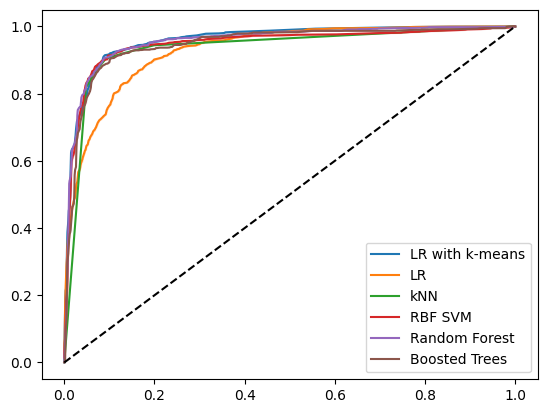

In [46]:
### 結果をプロット

plt.figure()
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
sns.lineplot(x=fpr_cluster, y=tpr_cluster, label='LR with k-means')

for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    sns.lineplot(x=fpr, y=tpr, label=classifier_names[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()